Many thanks to Jasper and her kernel hier: https://www.kaggle.com/jesperdramsch/intro-to-dicom-chest-xrays-data-viz-and-unets
Taking a look at her kernel is worth the while. This kernel is based on Jasper's kernel with the goal to visualize all 10 images.
I was wandering if un untrained eye can see the Pneumothorax on these sample images. I can honestly say, I can't see anything. Can you? Please leave a comment :) 

In [1]:
import os
import glob

import pydicom

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import patches as patches

import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '../input')
from mask_functions import rle2mask

In [2]:
ls '../input/sample images/'

1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm
1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580.dcm
1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397.dcm
1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420.dcm
1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591.dcm
1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290.dcm
1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105.dcm
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709.dcm
1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576.dcm
train-rle-sample.csv


In [3]:
IMAGE_PATH = '../input/sample images/'
IMAGE_MEDIA_TYPE = '.dcm'
IMAGE_SIZE = 1024

In [4]:
train_rle_sample = pd.read_csv(IMAGE_PATH + 'train-rle-sample.csv', header=None, index_col=0)
train_rle_sample.head(10).reset_index()

0                                                  1
0  1.2.276.0.7230010.3.1.4.8323329.1000.151787516...                                                 -1
1  1.2.276.0.7230010.3.1.4.8323329.10000.15178752...                                                 -1
2  1.2.276.0.7230010.3.1.4.8323329.10001.15178752...                                                 -1
3  1.2.276.0.7230010.3.1.4.8323329.10002.15178752...                                                 -1
4  1.2.276.0.7230010.3.1.4.8323329.10003.15178752...                                                 -1
5  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   175349 7 1013 12 1009 17 1005 19 1003 20 1002...
6  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   119331 47 972 82 937 107 912 122 897 137 882 ...
7  1.2.276.0.7230010.3.1.4.8323329.4440.151787518...   532609 13 1005 19 1002 21 999 25 989 32 988 3...
8  1.2.276.0.7230010.3.1.4.8323329.4982.151787518...   291062 6 1015 10 1013 11 1011 13 1010 13 1010...
9  1.2.276.0.7230010.3.1.4.8323329.12743.15178752...   810584 20 1003 22 1001 25 998 28 994 32 990 3...

The first five images are clean, the last five images have pneumothorax.

In [5]:
def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def show_dcm_info(dataset, image_name):
    print("Image............:", image_name)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()
    
def plot_with_mask_and_bbox(dataset, mask_encoded, figsize=(20,10)):
    mask_decoded = rle2mask(mask_encoded, 1024, 1024).T
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
    rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
    patch = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
    ax[0].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    ax[0].imshow(mask_decoded, alpha=0.3, cmap="Reds")
    ax[0].add_patch(patch)
    ax[0].set_title('With Mask')

    patch = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1,edgecolor='r',facecolor='none')
    ax[1].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    ax[1].add_patch(patch)
    ax[1].set_title('Without Mask')
    plt.show()

def show_image(image_name):
    dataset = pydicom.dcmread(IMAGE_PATH + image_name + IMAGE_MEDIA_TYPE)
    show_dcm_info(dataset, image_name)
    
    mask_encoded = train_rle_sample.loc[image_name].values[0]
    if mask_encoded == '-1':    
        plot_pixel_array(dataset)
    else:
        plot_with_mask_and_bbox(dataset, mask_encoded)

Let's see the first five images - without pneumothorax.

Image............: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: ['0.168', '0.168']


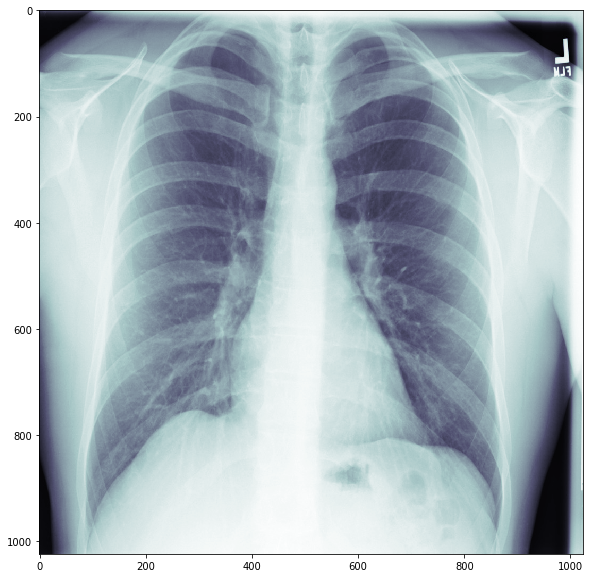

In [6]:
show_image('1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027')

Image............: 1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 8ab1ffda-8b65-4914-95d6-2e549e328666, 
Patient id..........: 8ab1ffda-8b65-4914-95d6-2e549e328666
Patient's Age.......: 10
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 116234 bytes
Pixel spacing....: ['0.139', '0.139']


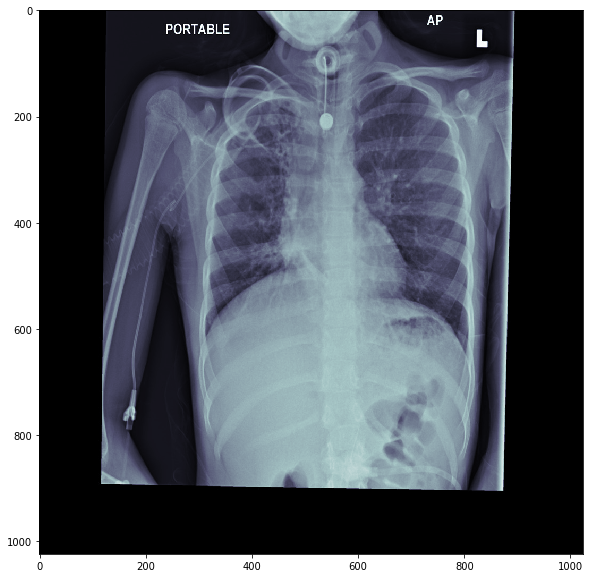

In [7]:
show_image('1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530')

Image............: 1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: bfef51d3-6541-4792-bac1-d21d41ee60fd, 
Patient id..........: bfef51d3-6541-4792-bac1-d21d41ee60fd
Patient's Age.......: 50
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 111080 bytes
Pixel spacing....: ['0.168', '0.168']


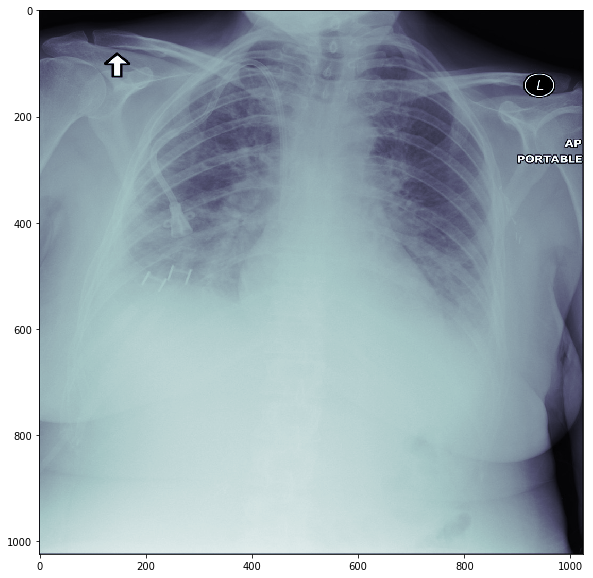

In [8]:
show_image('1.2.276.0.7230010.3.1.4.8323329.10001.1517875220.930580')

Image............: 1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: d19d956f-4ddd-4688-81ff-909c85e0e2d9, 
Patient id..........: d19d956f-4ddd-4688-81ff-909c85e0e2d9
Patient's Age.......: 68
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 155090 bytes
Pixel spacing....: ['0.139', '0.139']


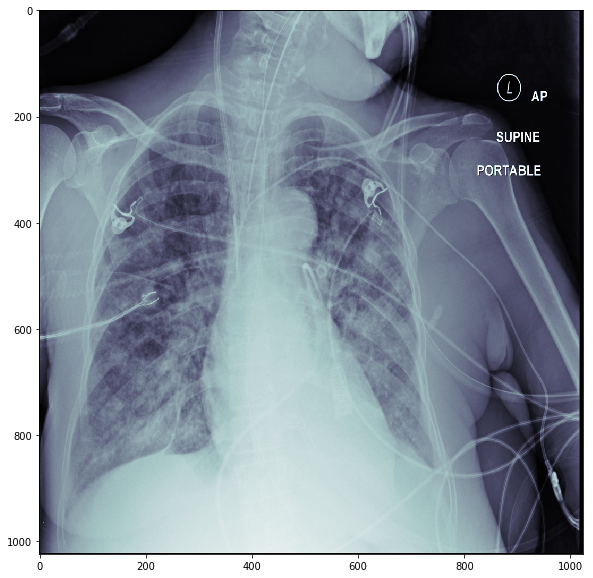

In [9]:
show_image('1.2.276.0.7230010.3.1.4.8323329.10002.1517875220.939397')

Image............: 1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: cf71a760-f693-4ccf-acd4-a41ff4845a5f, 
Patient id..........: cf71a760-f693-4ccf-acd4-a41ff4845a5f
Patient's Age.......: 65
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 111914 bytes
Pixel spacing....: ['0.168', '0.168']


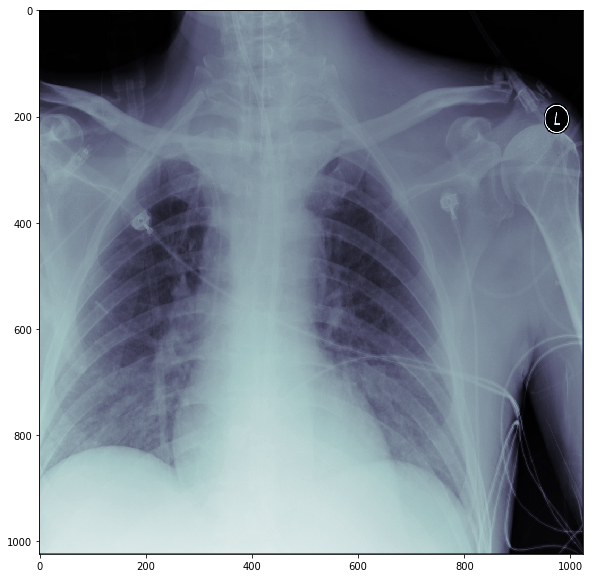

In [10]:
show_image('1.2.276.0.7230010.3.1.4.8323329.10003.1517875220.942420')

Not let's take a look at the images with Pneumothorax...

Image............: 1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fef0ab32-8eb1-442e-93a3-2dd0162cc53a, 
Patient id..........: fef0ab32-8eb1-442e-93a3-2dd0162cc53a
Patient's Age.......: 69
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 173806 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


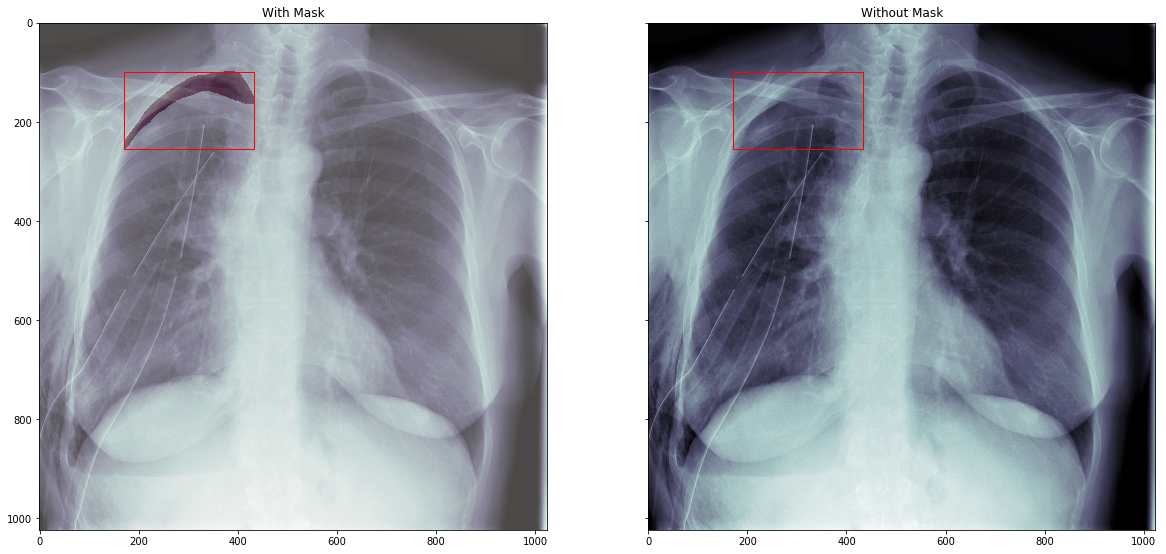

In [11]:
show_image('1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709')

Image............: 1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fe7975db-807a-49ff-962d-d35686225255, 
Patient id..........: fe7975db-807a-49ff-962d-d35686225255
Patient's Age.......: 16
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 150700 bytes
Pixel spacing....: ['0.14300000000000002', '0.14300000000000002']


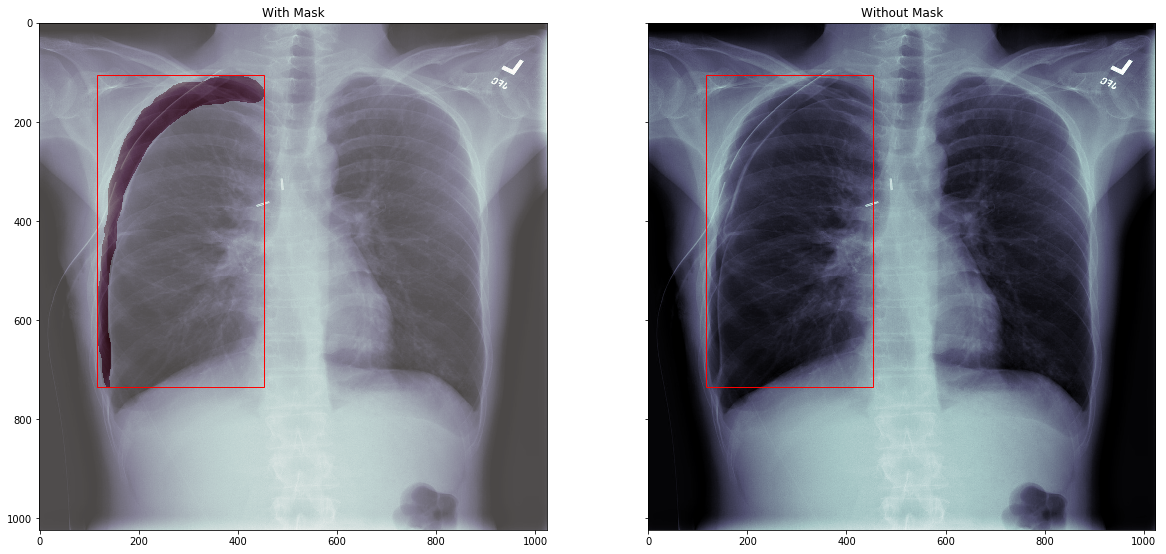

In [12]:
show_image('1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290')

Image............: 1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fdccd800-6a1f-4111-824a-f2ddd879228d, 
Patient id..........: fdccd800-6a1f-4111-824a-f2ddd879228d
Patient's Age.......: 65
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 148880 bytes
Pixel spacing....: ['0.139', '0.139']


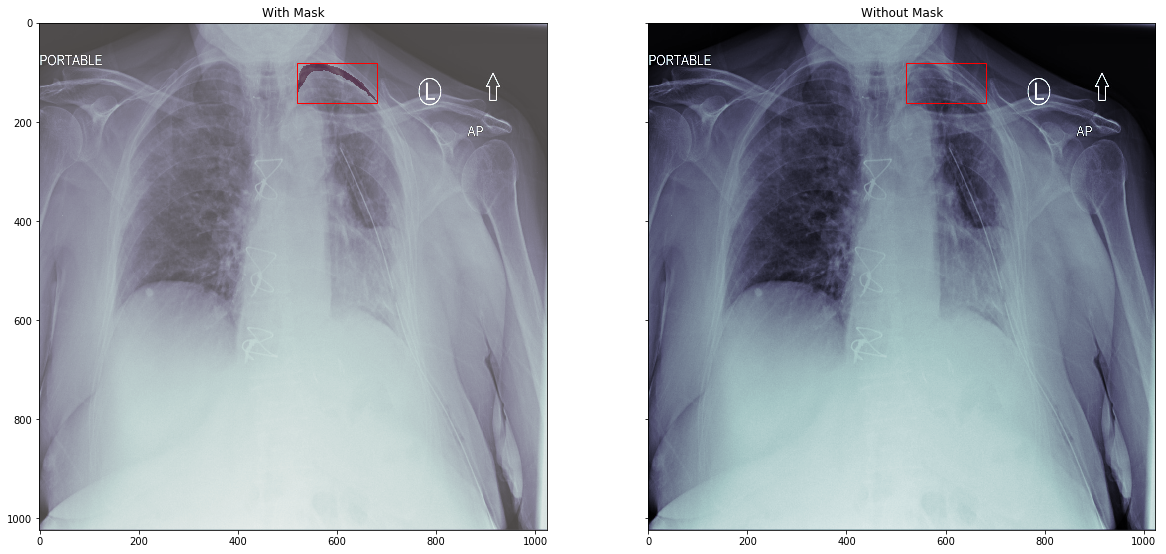

In [13]:
show_image('1.2.276.0.7230010.3.1.4.8323329.4440.1517875182.865105')

Image............: 1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fd903dff-4b47-4598-99bb-2ec488eb2c31, 
Patient id..........: fd903dff-4b47-4598-99bb-2ec488eb2c31
Patient's Age.......: 56
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 134952 bytes
Pixel spacing....: ['0.19431099999999998', '0.19431099999999998']


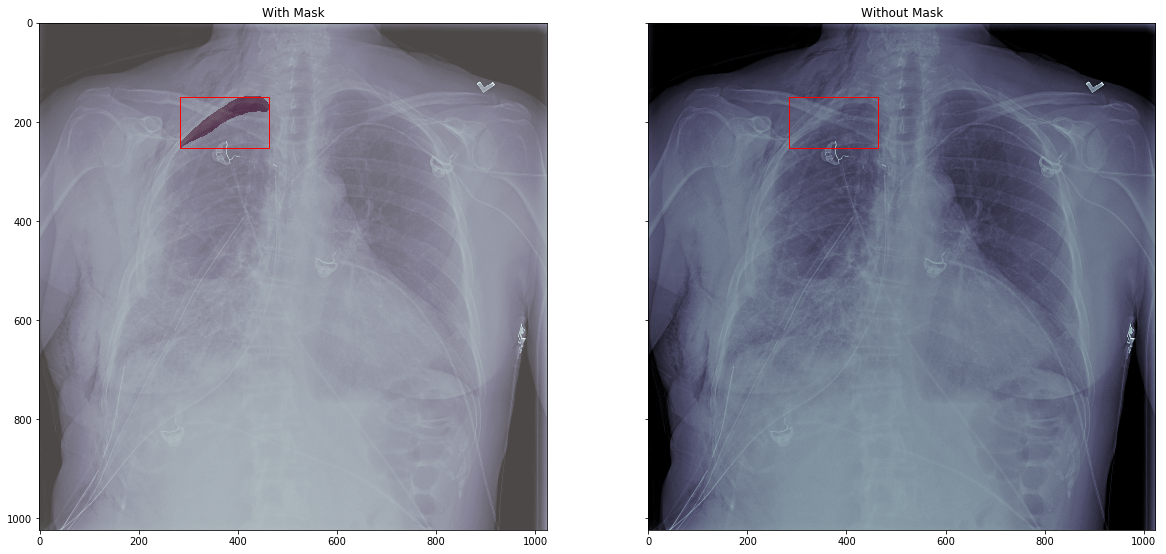

In [14]:
show_image('1.2.276.0.7230010.3.1.4.8323329.4982.1517875185.837576')

Image............: 1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: fcb8a3cf-9449-4186-b29c-db5b93c9c75c, 
Patient id..........: fcb8a3cf-9449-4186-b29c-db5b93c9c75c
Patient's Age.......: 28
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 112200 bytes
Pixel spacing....: ['0.19431099999999998', '0.19431099999999998']


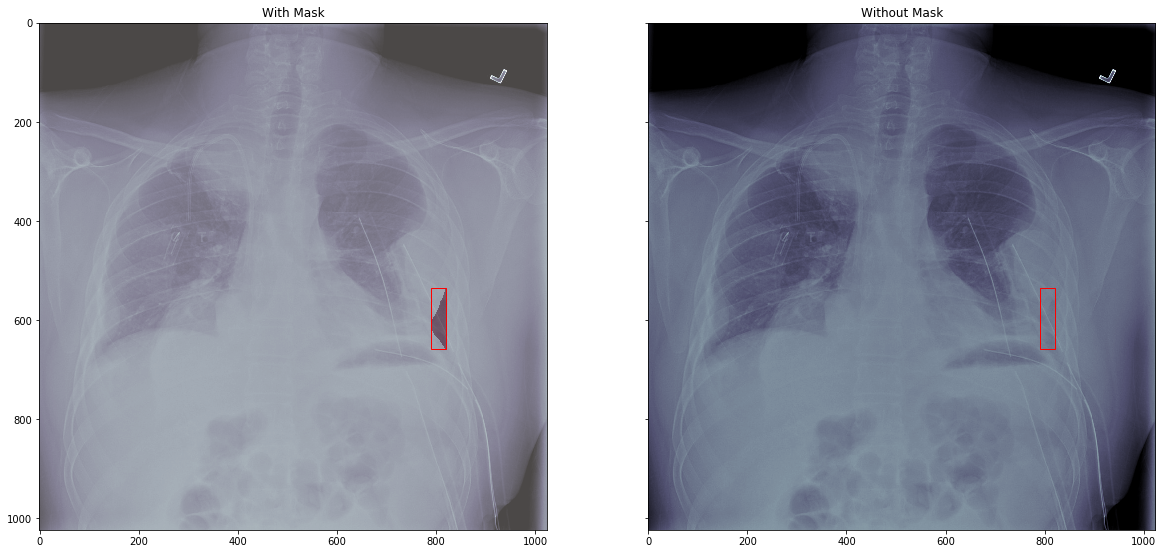

In [15]:
show_image('1.2.276.0.7230010.3.1.4.8323329.12743.1517875241.599591')